# **Import Library & Load Dataset**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pickle
import requests
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Machine-Learning/AirQualityUCI.csv', sep=';')

Mounted at /content/drive


# **Preprocessing Data**

In [ ]:
df = df[df[df.columns[2:]].notna().any(axis=1)]

In [ ]:
numeric_cols = df.columns[2:15]

In [ ]:
for col in numeric_cols:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(',', '.').astype(float)

df[numeric_cols] = df[numeric_cols].replace(-200, np.nan)
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

In [ ]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')
df = df.dropna(subset=['Datetime'])
df = df.sort_values('Datetime')
df['Hour'] = df['Datetime'].dt.hour
df['Day'] = df['Datetime'].dt.day
df['Month'] = df['Datetime'].dt.month
df['Year'] = df['Datetime'].dt.year
df.drop(['Date', 'Time', 'Datetime'], axis=1, inplace=True)

In [ ]:
print("Distribusi CO(GT):", df['CO(GT)'].describe())
worst = df.nlargest(10, 'CO(GT)')[['CO(GT)', 'Hour', 'Day', 'Month', 'Year']]
print("\nRentang Waktu Terburuk (Top 10 CO):", worst)
monthly_co = df.groupby('Month')['CO(GT)'].mean()
print("\nRata-rata CO per Bulan:", monthly_co)
hourly_co = df.groupby('Hour')['CO(GT)'].mean()
print("\nRata-rata CO per Jam:", hourly_co)

Distribusi CO(GT): count    9357.000000
mean        2.152750
std         1.316068
min         0.100000
25%         1.200000
50%         2.152750
75%         2.600000
max        11.900000
Name: CO(GT), dtype: float64

Rentang Waktu Terburuk (Top 10 CO):       CO(GT)  Hour  Day  Month  Year
6193    11.9    19   23     11  2004
6194    11.5    20   23     11  2004
6048    10.2    18   17     11  2004
6192    10.2    18   23     11  2004
6264    10.1    18   26     11  2004
6672     9.9    18   13     12  2004
5520     9.5    18   26     10  2004
6409     9.4    19    2     12  2004
6696     9.3    18   14     12  2004
5690     9.2    20    2     11  2004

Rata-rata CO per Bulan: Month
1     2.136676
2     2.096986
3     2.144342
4     2.145693
5     1.983492
6     1.926679
7     1.876897
8     1.593258
9     2.161599
10    2.454859
11    2.655087
12    2.667589
Name: CO(GT), dtype: float64

Rata-rata CO per Jam: Hour
0     1.843379
1     1.585472
2     1.288186
3     1.141319
4     1.5128

# **Pembuatan Label untuk Klasifikasi dan Prediksi**

In [ ]:
def calculate_aqi(pollutants):
    co_bps = [(0, 4.4, 0, 50), (4.5, 9.4, 51, 100), (9.5, 12.4, 101, 150), (12.5, 15.4, 151, 200)]
    no2_bps = [(0, 53, 0, 50), (54, 100, 51, 100), (101, 360, 101, 150), (361, 649, 151, 200)]
    c6h6_bps = [(0, 5, 0, 50), (6, 10, 51, 100), (11, 20, 101, 150)]  # Proxy VOC
    sub_indices = []

    def sub_index(val, bps):
        for lo, hi, i_lo, i_hi in bps:
            if lo <= val <= hi:
                return ((i_hi - i_lo) / (hi - lo)) * (val - lo) + i_lo
        return 0

    if 'CO(GT)' in pollutants:
        sub_indices.append(sub_index(pollutants['CO(GT)'], co_bps))
    if 'NO2(GT)' in pollutants:
        sub_indices.append(sub_index(pollutants['NO2(GT)'], no2_bps))
    if 'C6H6(GT)' in pollutants:
        sub_indices.append(sub_index(pollutants['C6H6(GT)'], c6h6_bps))

    aqi = max(sub_indices) if sub_indices else 0
    if aqi <= 50: category = "Good"
    elif aqi <= 100: category = "Moderate"
    elif aqi <= 150: category = "Unhealthy for Sensitive Groups"
    else: category = "Unhealthy"
    return aqi, category

# **Normalisasi data untuk Regresi**

In [ ]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df)
features_scaled = np.nan_to_num(features_scaled)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Untuk Single Target Polutan berupa CO(GT)

In [ ]:
single_target_col = 'CO(GT)'
single_target_idx = df.columns.get_loc(single_target_col)
X_single = np.delete(features_scaled, single_target_idx, axis=1)
y_single = features_scaled[:, single_target_idx]

Untuk Multi Polutan seperti CO, NO2, C6H6

In [ ]:
multi_target_cols = ['CO(GT)', 'NO2(GT)', 'C6H6(GT)']
multi_target_idxs = [df.columns.get_loc(c) for c in multi_target_cols]
X_multi = np.delete(features_scaled, multi_target_idxs, axis=1)
y_multi = features_scaled[:, multi_target_idxs]

Untuk melakukan prediksi selama 24 jam kedepan pada single target

In [ ]:
def create_sequences(data, seq_len=24, pred_len=1, target_idx=single_target_idx):
    xs, ys = [], []
    for i in range(len(data) - seq_len - pred_len):
        x = data[i:i+seq_len]
        y = data[i+seq_len:i+seq_len+pred_len, target_idx]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [ ]:
seq_len = 24
pred_len = 24
X_seq, y_seq = create_sequences(features_scaled, seq_len, pred_len)
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(X_train_seq, y_train_seq, test_size=0.2, random_state=42)

In [ ]:
X_train_single, X_test_single, y_train_single, y_test_single = train_test_split(X_single, y_single, test_size=0.2, random_state=42)
X_train_single, X_val_single, y_train_single, y_val_single = train_test_split(X_train_single, y_train_single, test_size=0.2, random_state=42)

In [ ]:
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)
X_train_multi, X_val_multi, y_train_multi, y_val_multi = train_test_split(X_train_multi, y_train_multi, test_size=0.2, random_state=42)

In [ ]:
pickle.dump(scaler, open('scaler.pkl', 'wb'))

# **Visualisasi pada proses yang dilakukan**

In [ ]:
def plot_history(history, name):
    plt.figure(figsize=(6, 4))
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{name} Loss')
    plt.ylim(0, max(max(history['loss']), max(history['val_loss'])) + 0.1)
    plt.legend()
    plt.savefig(f'{name}_loss_plot.png')
    plt.show()

In [ ]:
def plot_accuracy_history(history, name):
    if 'val_accuracy' in history:
        plt.figure(figsize=(6, 4))
        plt.plot(history['val_accuracy'], label='Val Accuracy')
        plt.title(f'{name} Validation Accuracy')
        plt.ylim(0, 1.1)
        plt.legend()
        plt.savefig(f'{name}_accuracy_plot.png')
        plt.show()

In [ ]:
def create_loaders(X_t, y_t, X_v, y_v, X_te, y_te, bs=64, is_seq=False):
    if is_seq:
        y_t = y_t.reshape(-1, pred_len) if y_t.ndim == 1 else y_t
        y_v = y_v.reshape(-1, pred_len) if y_v.ndim == 1 else y_v
        y_te = y_te.reshape(-1, pred_len) if y_te.ndim == 1 else y_te
    train_ds = TensorDataset(torch.tensor(X_t).float(), torch.tensor(y_t).float())
    val_ds = TensorDataset(torch.tensor(X_v).float(), torch.tensor(y_v).float())
    test_ds = TensorDataset(torch.tensor(X_te).float(), torch.tensor(y_te).float())
    return DataLoader(train_ds, batch_size=bs, shuffle=not is_seq), DataLoader(val_ds, batch_size=bs), DataLoader(test_ds, batch_size=bs)

In [ ]:
def compute_aqi_accuracy(model, loader, is_multi=False, is_seq=False, target_cols=None, target_idx=single_target_idx, target_idxs=multi_target_idxs, scaler=scaler):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data, target in loader:
            out = model(data)
            if not is_seq:
                out = out.squeeze() if not is_multi else out
            y_pred.append(out.cpu().numpy())
            y_true.append(target.cpu().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    if is_multi:
        dummy_true = np.zeros((len(y_true), features_scaled.shape[1]))
        dummy_true[:, target_idxs] = y_true
        true_real = scaler.inverse_transform(dummy_true)[:, target_idxs]

        dummy_pred = np.zeros((len(y_pred), features_scaled.shape[1]))
        dummy_pred[:, target_idxs] = y_pred
        pred_real = scaler.inverse_transform(dummy_pred)[:, target_idxs]

        true_classes = []
        pred_classes = []
        for i in range(len(true_real)):
            true_poll = dict(zip(target_cols, true_real[i]))
            pred_poll = dict(zip(target_cols, pred_real[i]))
            _, true_cat = calculate_aqi(true_poll)
            _, pred_cat = calculate_aqi(pred_poll)
            true_classes.append(true_cat)
            pred_classes.append(pred_cat)
    else:
        if is_seq:
            true_classes = []
            pred_classes = []
            for samp in range(len(y_pred)):
                for i in range(pred_len):
                    dummy_true = np.zeros((1, features_scaled.shape[1]))
                    dummy_true[0, target_idx] = y_true[samp][i]
                    true_real = scaler.inverse_transform(dummy_true)[0, target_idx]
                    _, true_cat = calculate_aqi({'CO(GT)': true_real})
                    true_classes.append(true_cat)

                    dummy_pred = np.zeros((1, features_scaled.shape[1]))
                    dummy_pred[0, target_idx] = y_pred[samp][i]
                    pred_real = scaler.inverse_transform(dummy_pred)[0, target_idx]
                    _, pred_cat = calculate_aqi({'CO(GT)': pred_real})
                    pred_classes.append(pred_cat)
        else:
            dummy_true = np.zeros((len(y_true), features_scaled.shape[1]))
            dummy_true[:, target_idx] = y_true
            true_real = scaler.inverse_transform(dummy_true)[:, target_idx]

            dummy_pred = np.zeros((len(y_pred), features_scaled.shape[1]))
            dummy_pred[:, target_idx] = y_pred
            pred_real = scaler.inverse_transform(dummy_pred)[:, target_idx]

            true_classes = [calculate_aqi({'CO(GT)': val})[1] for val in true_real]
            pred_classes = [calculate_aqi({'CO(GT)': val})[1] for val in pred_real]

    return accuracy_score(true_classes, pred_classes)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50, patience=5, is_multi=False, is_seq=False, target_cols=None, target_idx=single_target_idx, target_idxs=multi_target_idxs, scaler=scaler):
    history = {'loss': [], 'val_loss': [], 'val_accuracy': []}
    best_val = float('inf')
    pat_count = 0
    for ep in range(epochs):
        model.train()
        tr_loss = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            out = model(data)
            if not is_seq:
                out = out.squeeze() if not is_multi else out
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            tr_loss += loss.item()
        history['loss'].append(tr_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                out = model(data)
                if not is_seq:
                    out = out.squeeze() if not is_multi else out
                val_loss += criterion(out, target).item()
        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)

        val_acc = compute_aqi_accuracy(model, val_loader, is_multi=is_multi, is_seq=is_seq, target_cols=target_cols, target_idx=target_idx, target_idxs=target_idxs, scaler=scaler)
        history['val_accuracy'].append(val_acc)
        print(f"Epoch {ep+1}/{epochs}, Val Loss: {val_loss:.4f}, Val Accuracy (AQI): {val_acc:.4f}")

        if val_loss < best_val:
            best_val = val_loss
            pat_count = 0
        else:
            pat_count += 1
            if pat_count >= patience:
                print(f"Early stop at epoch {ep+1}")
                break
    return history

In [ ]:
def evaluate(model, test_loader, name, is_multi=False, is_seq=False, target_cols=None, target_idx=single_target_idx, target_idxs=multi_target_idxs):
    model.eval()
    y_pred = []
    with torch.no_grad():
        for data, _ in test_loader:
            out = model(data)
            if not is_seq:
                out = out.squeeze() if not is_multi else out
            y_pred.append(out.cpu().numpy())
    y_pred = np.concatenate(y_pred)
    test_y = y_test_multi if is_multi else (y_test_seq if is_seq else y_test_single)
    mae = mean_absolute_error(test_y, y_pred)
    rmse = np.sqrt(mean_squared_error(test_y, y_pred))
    print(f"\n{name} MAE: {mae}, RMSE: {rmse}")

    if is_multi:
        dummy_true = np.zeros((len(test_y), features_scaled.shape[1]))
        dummy_true[:, target_idxs] = test_y
        true_real = scaler.inverse_transform(dummy_true)[:, target_idxs]

        dummy_pred = np.zeros((len(y_pred), features_scaled.shape[1]))
        dummy_pred[:, target_idxs] = y_pred
        pred_real = scaler.inverse_transform(dummy_pred)[:, target_idxs]

        true_classes = []
        pred_classes = []
        for i in range(len(true_real)):
            true_poll = dict(zip(target_cols, true_real[i]))
            pred_poll = dict(zip(target_cols, pred_real[i]))
            _, true_cat = calculate_aqi(true_poll)
            _, pred_cat = calculate_aqi(pred_poll)
            true_classes.append(true_cat)
            pred_classes.append(pred_cat)

        print(f"{name} Classification Report (AQI Classes):")
        print(classification_report(true_classes, pred_classes))
        print(f"{name} Confusion Matrix (AQI Classes):")
        classes = ["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy"]
        cm = confusion_matrix(true_classes, pred_classes, labels=classes)
        print(cm)

        fig, ax = plt.subplots(figsize=(8, 6))
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=classes, yticklabels=classes,
               title=f'Confusion Matrix - {name} (AQI Classes)',
               ylabel='True label',
               xlabel='Predicted label')
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{name}.png')
        plt.show()

        print(f"{name} Accuracy (AQI Classes): {accuracy_score(true_classes, pred_classes)}")

        aqi, category = calculate_aqi(pred_poll)
        print(f"Contoh Prediksi AQI: {aqi} ({category})")
    else:
        aqis_true = []
        aqis_pred = []
        true_classes = []
        pred_classes = []
        if is_seq:
            for samp in range(len(y_pred)):
                for i in range(pred_len):
                    dummy_true = np.zeros((1, features_scaled.shape[1]))
                    dummy_true[0, target_idx] = test_y[samp][i]
                    true_real = scaler.inverse_transform(dummy_true)[0, target_idx]
                    aqi_true, cat_true = calculate_aqi({'CO(GT)': true_real})
                    aqis_true.append(aqi_true)
                    true_classes.append(cat_true)

                    dummy_pred = np.zeros((1, features_scaled.shape[1]))
                    dummy_pred[0, target_idx] = y_pred[samp][i]
                    pred_real = scaler.inverse_transform(dummy_pred)[0, target_idx]
                    aqi_pred, cat_pred = calculate_aqi({'CO(GT)': pred_real})
                    aqis_pred.append(aqi_pred)
                    pred_classes.append(cat_pred)

            print(f"{name} Classification Report (AQI Classes 24 jam):")
            print(classification_report(true_classes, pred_classes))
            print(f"{name} Confusion Matrix (AQI Classes 24 jam):")
            classes = ["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy"]
            cm = confusion_matrix(true_classes, pred_classes, labels=classes)
            print(cm)

            fig, ax = plt.subplots(figsize=(8, 6))
            im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            ax.figure.colorbar(im, ax=ax)
            ax.set(xticks=np.arange(cm.shape[1]),
                   yticks=np.arange(cm.shape[0]),
                   xticklabels=classes, yticklabels=classes,
                   title=f'Confusion Matrix - {name} (AQI Classes 24 jam)',
                   ylabel='True label',
                   xlabel='Predicted label')
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
            thresh = cm.max() / 2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    ax.text(j, i, format(cm[i, j], 'd'),
                            ha="center", va="center",
                            color="white" if cm[i, j] > thresh else "black")
            plt.tight_layout()
            plt.savefig(f'confusion_matrix_{name}.png')
            plt.show()

            print(f"{name} Accuracy (AQI Classes 24 jam): {accuracy_score(true_classes, pred_classes)}")

            print(f"Max AQI 24 jam (Pred): {max(aqis_pred)}")
            print(f"Rata-rata AQI 24 jam (Pred): {np.mean(aqis_pred)}")
            print(f"Worst-case AQI 24 jam (Pred): {max(aqis_pred)}")
        else:
            dummy_true = np.zeros((len(test_y), features_scaled.shape[1]))
            dummy_true[:, target_idx] = test_y
            true_real = scaler.inverse_transform(dummy_true)[:, target_idx]

            dummy_pred = np.zeros((len(y_pred), features_scaled.shape[1]))
            dummy_pred[:, target_idx] = y_pred
            pred_real = scaler.inverse_transform(dummy_pred)[:, target_idx]

            true_classes = [calculate_aqi({'CO(GT)': val})[1] for val in true_real]
            pred_classes = [calculate_aqi({'CO(GT)': val})[1] for val in pred_real]

            print(f"{name} Classification Report (AQI Classes):")
            print(classification_report(true_classes, pred_classes))
            print(f"{name} Confusion Matrix (AQI Classes):")
            classes = ["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy"]
            cm = confusion_matrix(true_classes, pred_classes, labels=classes)
            print(cm)

            fig, ax = plt.subplots(figsize=(8, 6))
            im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            ax.figure.colorbar(im, ax=ax)
            ax.set(xticks=np.arange(cm.shape[1]),
                   yticks=np.arange(cm.shape[0]),
                   xticklabels=classes, yticklabels=classes,
                   title=f'Confusion Matrix - {name} (AQI Classes)',
                   ylabel='True label',
                   xlabel='Predicted label')
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
            thresh = cm.max() / 2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    ax.text(j, i, format(cm[i, j], 'd'),
                            ha="center", va="center",
                            color="white" if cm[i, j] > thresh else "black")
            plt.tight_layout()
            plt.savefig(f'confusion_matrix_{name}.png')
            plt.show()

            print(f"{name} Accuracy (AQI Classes): {accuracy_score(true_classes, pred_classes)}")

            aqi, category = calculate_aqi({'CO(GT)': pred_real[0]})
            print(f"Contoh Prediksi AQI: {aqi} ({category})")

criterion = nn.MSELoss()

# **Base Model berupa MLP untuk Single Polutan**

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, out_size=1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, out_size)
        )
    def forward(self, x):
        return self.layers(x)

Epoch 1/50, Val Loss: 0.1938, Val Accuracy (AQI): 0.9733
Epoch 2/50, Val Loss: 0.1768, Val Accuracy (AQI): 0.9719
Epoch 3/50, Val Loss: 0.1767, Val Accuracy (AQI): 0.9713
Epoch 4/50, Val Loss: 0.1768, Val Accuracy (AQI): 0.9739
Epoch 5/50, Val Loss: 0.1744, Val Accuracy (AQI): 0.9673
Epoch 6/50, Val Loss: 0.1631, Val Accuracy (AQI): 0.9719
Epoch 7/50, Val Loss: 0.1618, Val Accuracy (AQI): 0.9719
Epoch 8/50, Val Loss: 0.1787, Val Accuracy (AQI): 0.9699
Epoch 9/50, Val Loss: 0.1573, Val Accuracy (AQI): 0.9733
Epoch 10/50, Val Loss: 0.1599, Val Accuracy (AQI): 0.9733
Epoch 11/50, Val Loss: 0.1660, Val Accuracy (AQI): 0.9686
Epoch 12/50, Val Loss: 0.1635, Val Accuracy (AQI): 0.9719
Epoch 13/50, Val Loss: 0.1501, Val Accuracy (AQI): 0.9753
Epoch 14/50, Val Loss: 0.1522, Val Accuracy (AQI): 0.9753
Epoch 15/50, Val Loss: 0.1545, Val Accuracy (AQI): 0.9733
Epoch 16/50, Val Loss: 0.1544, Val Accuracy (AQI): 0.9746
Epoch 17/50, Val Loss: 0.1493, Val Accuracy (AQI): 0.9726
Epoch 18/50, Val Loss: 

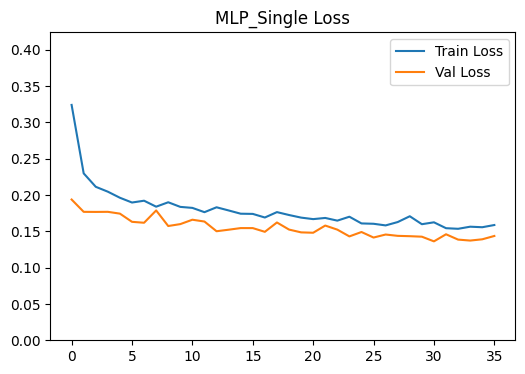

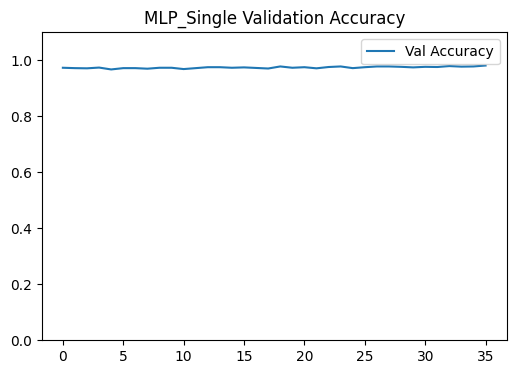


MLP_Single MAE: 0.2593131665731175, RMSE: 0.3690760420783162
MLP_Single Classification Report (AQI Classes):
                                precision    recall  f1-score   support

                          Good       0.98      0.99      0.99      1742
                      Moderate       0.88      0.76      0.82       126
Unhealthy for Sensitive Groups       1.00      0.50      0.67         4

                      accuracy                           0.98      1872
                     macro avg       0.95      0.75      0.82      1872
                  weighted avg       0.98      0.98      0.98      1872

MLP_Single Confusion Matrix (AQI Classes):
[[1731   11    0    0]
 [  30   96    0    0]
 [   0    2    2    0]
 [   0    0    0    0]]


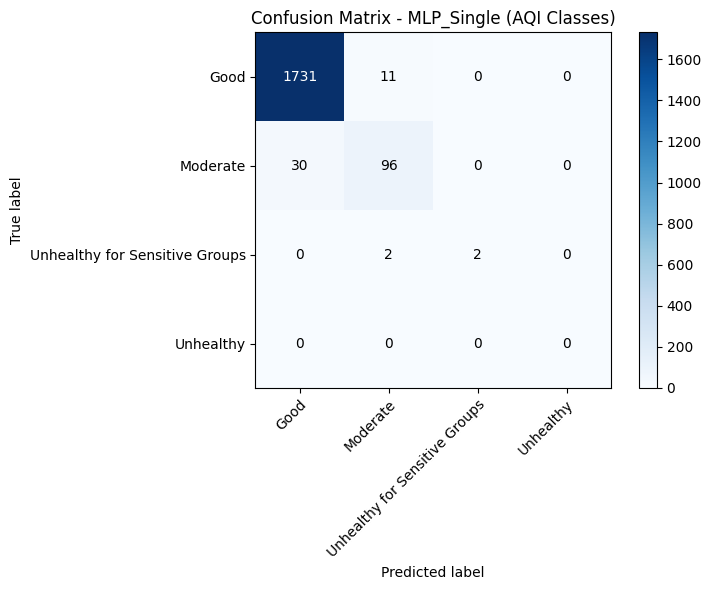

MLP_Single Accuracy (AQI Classes): 0.9770299145299145
Contoh Prediksi AQI: 14.2429866598135 (Good)


In [ ]:
mlp_single = MLP(X_train_single.shape[1])
opt_mlp_single = optim.Adam(mlp_single.parameters(), lr=0.001, weight_decay=1e-5)
train_l_single, val_l_single, test_l_single = create_loaders(X_train_single, y_train_single, X_val_single, y_val_single, X_test_single, y_test_single)
hist_mlp_single = train_model(mlp_single, train_l_single, val_l_single, criterion, opt_mlp_single, target_idx=single_target_idx, scaler=scaler)
plot_history(hist_mlp_single, 'MLP_Single')
plot_accuracy_history(hist_mlp_single, 'MLP_Single')
evaluate(mlp_single, test_l_single, 'MLP_Single', target_idx=single_target_idx)

torch.save(mlp_single.state_dict(), 'mlp_single.pth')
np.save('mlp_single_history.npy', np.array(hist_mlp_single, dtype=object))

Epoch 1/50, Val Loss: 0.1621, Val Accuracy (AQI): 0.7715
Epoch 2/50, Val Loss: 0.1380, Val Accuracy (AQI): 0.8323
Epoch 3/50, Val Loss: 0.1283, Val Accuracy (AQI): 0.8671
Epoch 4/50, Val Loss: 0.1175, Val Accuracy (AQI): 0.8597
Epoch 5/50, Val Loss: 0.1158, Val Accuracy (AQI): 0.8891
Epoch 6/50, Val Loss: 0.1141, Val Accuracy (AQI): 0.8951
Epoch 7/50, Val Loss: 0.1186, Val Accuracy (AQI): 0.9011
Epoch 8/50, Val Loss: 0.1056, Val Accuracy (AQI): 0.8884
Epoch 9/50, Val Loss: 0.1079, Val Accuracy (AQI): 0.8965
Epoch 10/50, Val Loss: 0.1042, Val Accuracy (AQI): 0.8831
Epoch 11/50, Val Loss: 0.1034, Val Accuracy (AQI): 0.8891
Epoch 12/50, Val Loss: 0.1050, Val Accuracy (AQI): 0.8971
Epoch 13/50, Val Loss: 0.1003, Val Accuracy (AQI): 0.9031
Epoch 14/50, Val Loss: 0.1022, Val Accuracy (AQI): 0.8958
Epoch 15/50, Val Loss: 0.1022, Val Accuracy (AQI): 0.9051
Epoch 16/50, Val Loss: 0.0973, Val Accuracy (AQI): 0.8998
Epoch 17/50, Val Loss: 0.0995, Val Accuracy (AQI): 0.8978
Epoch 18/50, Val Loss: 

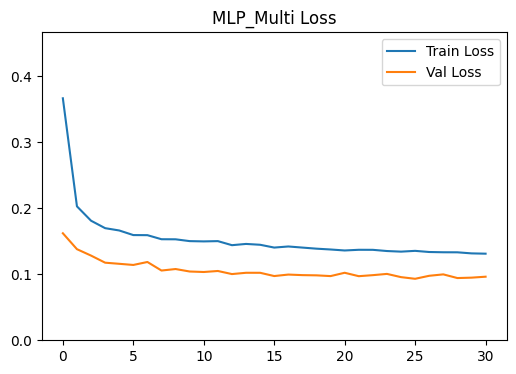

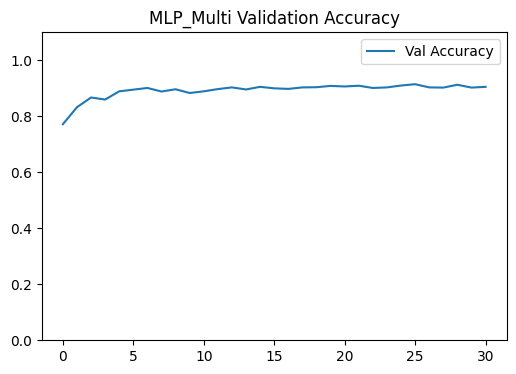


MLP_Multi MAE: 0.19310094797359956, RMSE: 0.3049272381568074
MLP_Multi Classification Report (AQI Classes):
                                precision    recall  f1-score   support

                          Good       0.86      0.73      0.79       131
                      Moderate       0.83      0.88      0.86       481
Unhealthy for Sensitive Groups       0.96      0.96      0.96      1260

                      accuracy                           0.92      1872
                     macro avg       0.88      0.86      0.87      1872
                  weighted avg       0.92      0.92      0.92      1872

MLP_Multi Confusion Matrix (AQI Classes):
[[  96   35    0    0]
 [  11  425   45    0]
 [   5   51 1204    0]
 [   0    0    0    0]]


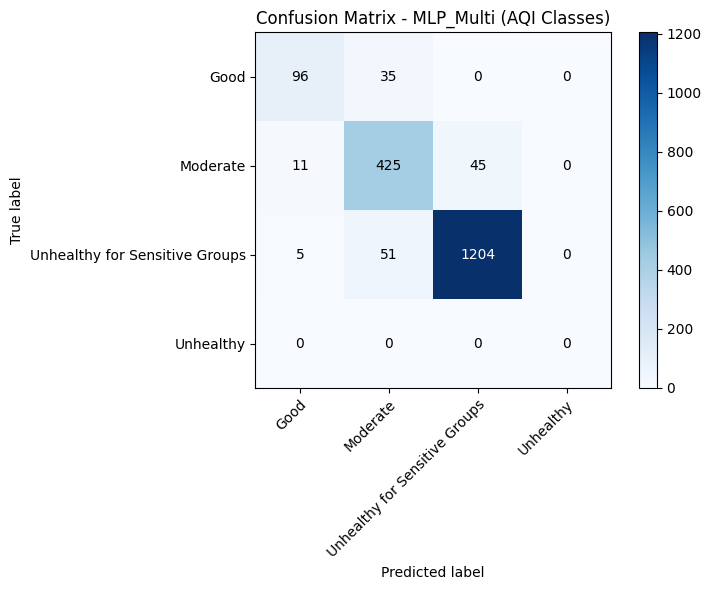

MLP_Multi Accuracy (AQI Classes): 0.9214743589743589
Contoh Prediksi AQI: 99.14136587003338 (Moderate)


In [ ]:
mlp_multi = MLP(X_train_multi.shape[1], len(multi_target_cols))
opt_mlp_multi = optim.Adam(mlp_multi.parameters(), lr=0.001, weight_decay=1e-5)
train_l_multi, val_l_multi, test_l_multi = create_loaders(X_train_multi, y_train_multi, X_val_multi, y_val_multi, X_test_multi, y_test_multi)
hist_mlp_multi = train_model(mlp_multi, train_l_multi, val_l_multi, criterion, opt_mlp_multi, is_multi=True, target_cols=multi_target_cols, target_idxs=multi_target_idxs, scaler=scaler)
plot_history(hist_mlp_multi, 'MLP_Multi')
plot_accuracy_history(hist_mlp_multi, 'MLP_Multi')
evaluate(mlp_multi, test_l_multi, 'MLP_Multi', is_multi=True, target_cols=multi_target_cols, target_idxs=multi_target_idxs)

torch.save(mlp_multi.state_dict(), 'mlp_multi.pth')
np.save('mlp_multi_history.npy', np.array(hist_mlp_multi, dtype=object))

# **Autoencoder menggunakan Pre-Trained Embedding untuk Single Regression**

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, emb=32):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_size, 64), nn.ReLU(), nn.Linear(64, emb))
        self.decoder = nn.Sequential(nn.Linear(emb, 64), nn.ReLU(), nn.Linear(64, input_size))
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
ae = Autoencoder(X_train_single.shape[1])
opt_ae = optim.Adam(ae.parameters(), lr=0.001)
crit_ae = nn.MSELoss()
train_full_l_single = DataLoader(TensorDataset(torch.tensor(X_train_single).float(), torch.tensor(X_train_single).float()), batch_size=64, shuffle=True)
for ep in range(30):
    ae.train()
    loss_ae = 0
    count = 0
    for data, target in train_full_l_single:
        opt_ae.zero_grad()
        recon = ae(data)
        loss = crit_ae(recon, target)
        if not torch.isnan(loss):
            loss.backward()
            opt_ae.step()
            loss_ae += loss.item()
            count += 1
    if count > 0:
        print(f"AE Epoch {ep}, Loss: {loss_ae / count}")

AE Epoch 0, Loss: 0.4343404587596021
AE Epoch 1, Loss: 0.07889133117141876
AE Epoch 2, Loss: 0.035674310071354215
AE Epoch 3, Loss: 0.023591639454218934
AE Epoch 4, Loss: 0.017140291849190883
AE Epoch 5, Loss: 0.013018870310104907
AE Epoch 6, Loss: 0.01045351007834394
AE Epoch 7, Loss: 0.008683653246175418
AE Epoch 8, Loss: 0.007013189294276402
AE Epoch 9, Loss: 0.005929605213013735
AE Epoch 10, Loss: 0.005174422938812604
AE Epoch 11, Loss: 0.004678835574676223
AE Epoch 12, Loss: 0.004270103272110065
AE Epoch 13, Loss: 0.003942731698539028
AE Epoch 14, Loss: 0.0036606602742277243
AE Epoch 15, Loss: 0.0034244738870914627
AE Epoch 16, Loss: 0.00322598634793007
AE Epoch 17, Loss: 0.0030662113270583623
AE Epoch 18, Loss: 0.0028550487056255656
AE Epoch 19, Loss: 0.0026814828136381
AE Epoch 20, Loss: 0.0025388011659317196
AE Epoch 21, Loss: 0.002390924003965994
AE Epoch 22, Loss: 0.0022364159887458416
AE Epoch 23, Loss: 0.0021279313789799494
AE Epoch 24, Loss: 0.0019735514379522587
AE Epoch 

In [ ]:
def get_emb(model, X):
    model.eval()
    with torch.no_grad():
        return model.encoder(torch.tensor(X).float()).cpu().numpy()

In [ ]:
X_train_emb = get_emb(ae, X_train_single)
X_val_emb = get_emb(ae, X_val_single)
X_test_emb = get_emb(ae, X_test_single)

In [ ]:
class AEReg(nn.Module):
    def __init__(self, emb):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(emb, 32), nn.ReLU(), nn.Dropout(0.2), nn.Linear(32, 1))
    def forward(self, x):
        return self.layers(x)

Epoch 1/50, Val Loss: 0.2431, Val Accuracy (AQI): 0.9666
Epoch 2/50, Val Loss: 0.2042, Val Accuracy (AQI): 0.9726
Epoch 3/50, Val Loss: 0.1976, Val Accuracy (AQI): 0.9739
Epoch 4/50, Val Loss: 0.1920, Val Accuracy (AQI): 0.9733
Epoch 5/50, Val Loss: 0.1933, Val Accuracy (AQI): 0.9686
Epoch 6/50, Val Loss: 0.1842, Val Accuracy (AQI): 0.9706
Epoch 7/50, Val Loss: 0.1829, Val Accuracy (AQI): 0.9686
Epoch 8/50, Val Loss: 0.1811, Val Accuracy (AQI): 0.9686
Epoch 9/50, Val Loss: 0.1771, Val Accuracy (AQI): 0.9713
Epoch 10/50, Val Loss: 0.1771, Val Accuracy (AQI): 0.9706
Epoch 11/50, Val Loss: 0.1754, Val Accuracy (AQI): 0.9719
Epoch 12/50, Val Loss: 0.1729, Val Accuracy (AQI): 0.9693
Epoch 13/50, Val Loss: 0.1720, Val Accuracy (AQI): 0.9746
Epoch 14/50, Val Loss: 0.1719, Val Accuracy (AQI): 0.9699
Epoch 15/50, Val Loss: 0.1717, Val Accuracy (AQI): 0.9679
Epoch 16/50, Val Loss: 0.1737, Val Accuracy (AQI): 0.9673
Epoch 17/50, Val Loss: 0.1734, Val Accuracy (AQI): 0.9666
Epoch 18/50, Val Loss: 

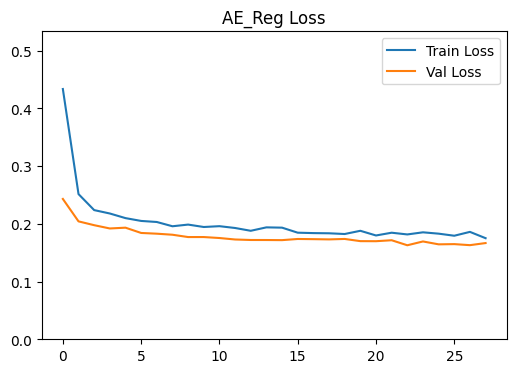

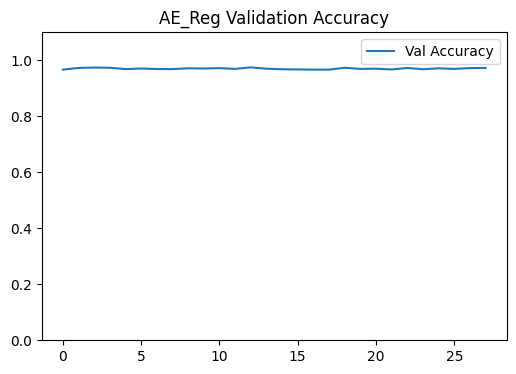


AE_Reg MAE: 0.2744377833928469, RMSE: 0.396027538303824
AE_Reg Classification Report (AQI Classes):
                                precision    recall  f1-score   support

                          Good       0.98      0.99      0.99      1742
                      Moderate       0.87      0.71      0.79       126
Unhealthy for Sensitive Groups       1.00      0.50      0.67         4

                      accuracy                           0.97      1872
                     macro avg       0.95      0.74      0.81      1872
                  weighted avg       0.97      0.97      0.97      1872

AE_Reg Confusion Matrix (AQI Classes):
[[1731   11    0    0]
 [  36   90    0    0]
 [   0    2    2    0]
 [   0    0    0    0]]


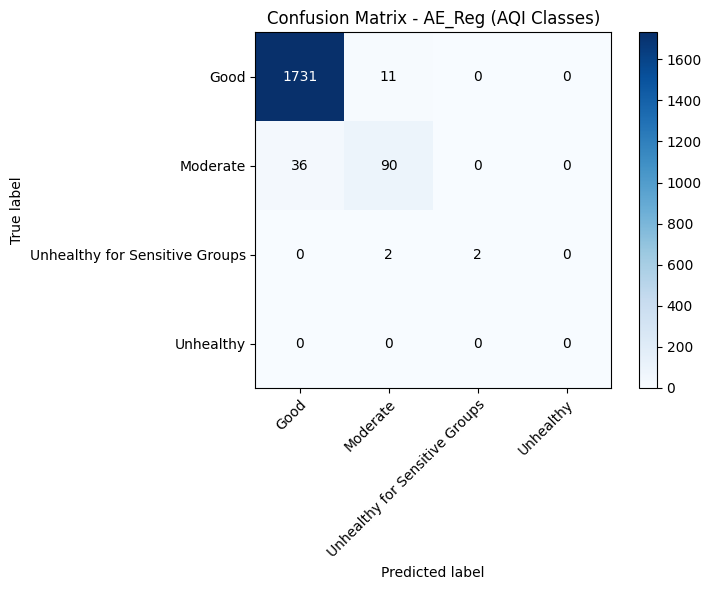

AE_Reg Accuracy (AQI Classes): 0.9738247863247863
Contoh Prediksi AQI: 15.403404163528034 (Good)


In [ ]:
ae_reg = AEReg(X_train_emb.shape[1])
opt_ae_reg = optim.Adam(ae_reg.parameters(), lr=0.001, weight_decay=1e-5)
ae_train_l, ae_val_l, ae_test_l = create_loaders(X_train_emb, y_train_single, X_val_emb, y_val_single, X_test_emb, y_test_single)
hist_ae = train_model(ae_reg, ae_train_l, ae_val_l, criterion, opt_ae_reg, target_idx=single_target_idx, scaler=scaler)
plot_history(hist_ae, 'AE_Reg')
plot_accuracy_history(hist_ae, 'AE_Reg')
evaluate(ae_reg, ae_test_l, 'AE_Reg', target_idx=single_target_idx)

In [ ]:
torch.save(ae.state_dict(), 'autoencoder.pth')
torch.save(ae_reg.state_dict(), 'ae_reg.pth')
np.save('ae_history.npy', np.array(hist_ae, dtype=object))

# **SimpleFT-Transformer untuk Single Polutan**

In [ ]:
class SimpleFTTransformer(nn.Module):
    def __init__(self, input_size, emb=32, heads=2, layers=2):
        super().__init__()
        self.emb = nn.Linear(input_size, emb)
        enc_layer = nn.TransformerEncoderLayer(d_model=emb, nhead=heads, dropout=0.1, batch_first=True)
        self.trans = nn.TransformerEncoder(enc_layer, num_layers=layers)
        self.fc = nn.Linear(emb, 1)

    def forward(self, x):
        x = self.emb(x).unsqueeze(1)
        x = self.trans(x).mean(dim=1)
        return self.fc(x)

Epoch 1/50, Val Loss: 0.2059, Val Accuracy (AQI): 0.9713
Epoch 2/50, Val Loss: 0.1908, Val Accuracy (AQI): 0.9733
Epoch 3/50, Val Loss: 0.2034, Val Accuracy (AQI): 0.9653
Epoch 4/50, Val Loss: 0.2132, Val Accuracy (AQI): 0.9699
Epoch 5/50, Val Loss: 0.1598, Val Accuracy (AQI): 0.9726
Epoch 6/50, Val Loss: 0.1795, Val Accuracy (AQI): 0.9713
Epoch 7/50, Val Loss: 0.1610, Val Accuracy (AQI): 0.9739
Epoch 8/50, Val Loss: 0.1732, Val Accuracy (AQI): 0.9806
Epoch 9/50, Val Loss: 0.1643, Val Accuracy (AQI): 0.9780
Epoch 10/50, Val Loss: 0.1528, Val Accuracy (AQI): 0.9733
Epoch 11/50, Val Loss: 0.1471, Val Accuracy (AQI): 0.9813
Epoch 12/50, Val Loss: 0.1527, Val Accuracy (AQI): 0.9800
Epoch 13/50, Val Loss: 0.1601, Val Accuracy (AQI): 0.9746
Epoch 14/50, Val Loss: 0.1596, Val Accuracy (AQI): 0.9739
Epoch 15/50, Val Loss: 0.1496, Val Accuracy (AQI): 0.9793
Epoch 16/50, Val Loss: 0.1636, Val Accuracy (AQI): 0.9766
Early stop at epoch 16


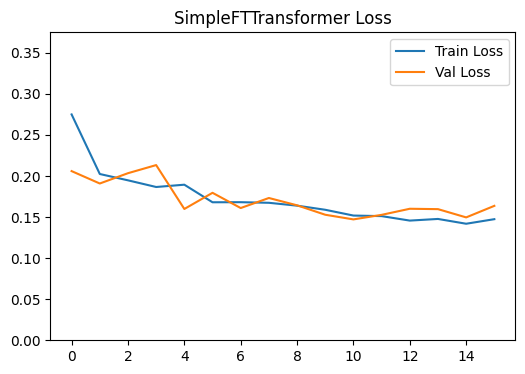

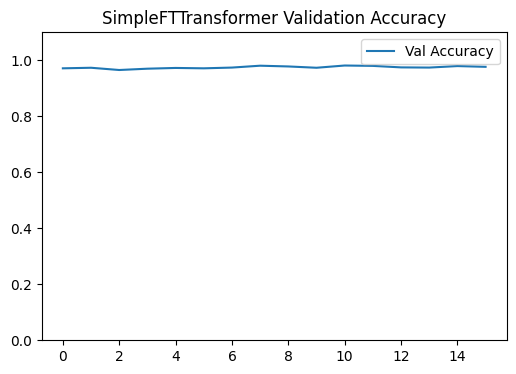


SimpleFTTransformer MAE: 0.27563188610323414, RMSE: 0.4016140472796028
SimpleFTTransformer Classification Report (AQI Classes):
                                precision    recall  f1-score   support

                          Good       0.97      1.00      0.98      1742
                      Moderate       0.87      0.64      0.74       126
Unhealthy for Sensitive Groups       0.00      0.00      0.00         4

                      accuracy                           0.97      1872
                     macro avg       0.62      0.55      0.57      1872
                  weighted avg       0.97      0.97      0.97      1872

SimpleFTTransformer Confusion Matrix (AQI Classes):
[[1734    8    0    0]
 [  45   81    0    0]
 [   0    4    0    0]
 [   0    0    0    0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


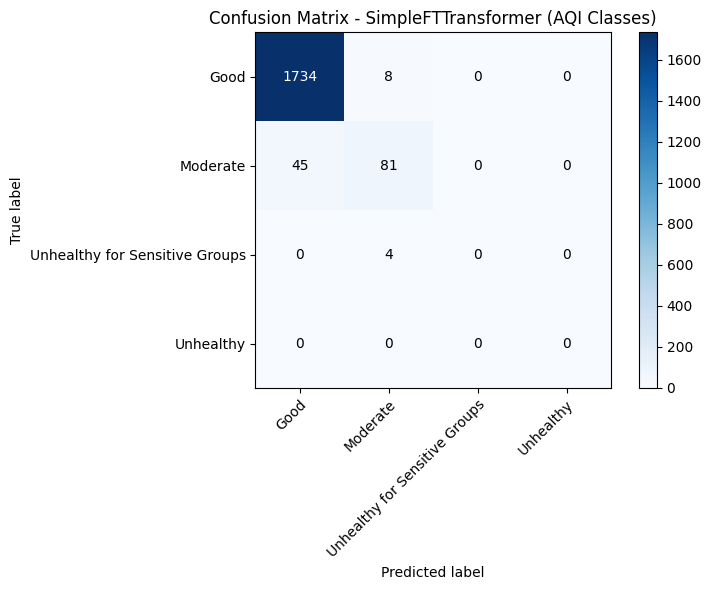

SimpleFTTransformer Accuracy (AQI Classes): 0.969551282051282
Contoh Prediksi AQI: 11.26816689837987 (Good)


In [ ]:
ft = SimpleFTTransformer(X_train_single.shape[1])
opt_ft = optim.Adam(ft.parameters(), lr=0.001, weight_decay=1e-5)
hist_ft = train_model(ft, train_l_single, val_l_single, criterion, opt_ft, target_idx=single_target_idx, scaler=scaler)
plot_history(hist_ft, 'SimpleFTTransformer')
plot_accuracy_history(hist_ft, 'SimpleFTTransformer')
evaluate(ft, test_l_single, 'SimpleFTTransformer', target_idx=single_target_idx)

torch.save(ft.state_dict(), 'simple_ft.pth')
np.save('ft_history.npy', np.array(hist_ft, dtype=object))

# **LSTM untuk time-series jangka pendek**

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden=128, layers=2, out_size=pred_len):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden, layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden, out_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

Epoch 1/50, Val Loss: 0.6154, Val Accuracy (AQI): 0.9380
Epoch 2/50, Val Loss: 0.5285, Val Accuracy (AQI): 0.9405
Epoch 3/50, Val Loss: 0.4880, Val Accuracy (AQI): 0.9416
Epoch 4/50, Val Loss: 0.4501, Val Accuracy (AQI): 0.9434
Epoch 5/50, Val Loss: 0.4129, Val Accuracy (AQI): 0.9462
Epoch 6/50, Val Loss: 0.3753, Val Accuracy (AQI): 0.9487
Epoch 7/50, Val Loss: 0.3338, Val Accuracy (AQI): 0.9525
Epoch 8/50, Val Loss: 0.3045, Val Accuracy (AQI): 0.9555
Epoch 9/50, Val Loss: 0.2865, Val Accuracy (AQI): 0.9571
Epoch 10/50, Val Loss: 0.2707, Val Accuracy (AQI): 0.9591
Epoch 11/50, Val Loss: 0.2564, Val Accuracy (AQI): 0.9614
Epoch 12/50, Val Loss: 0.2380, Val Accuracy (AQI): 0.9619
Epoch 13/50, Val Loss: 0.2259, Val Accuracy (AQI): 0.9626
Epoch 14/50, Val Loss: 0.2240, Val Accuracy (AQI): 0.9627
Epoch 15/50, Val Loss: 0.2169, Val Accuracy (AQI): 0.9630
Epoch 16/50, Val Loss: 0.2028, Val Accuracy (AQI): 0.9636
Epoch 17/50, Val Loss: 0.1998, Val Accuracy (AQI): 0.9648
Epoch 18/50, Val Loss: 

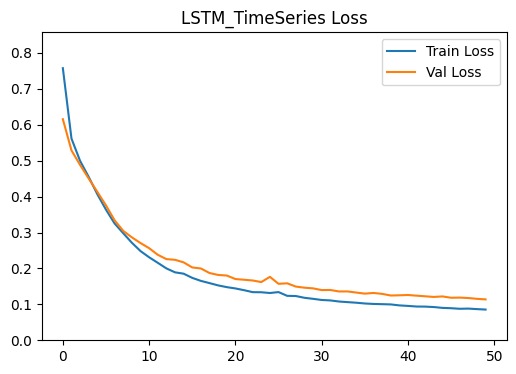

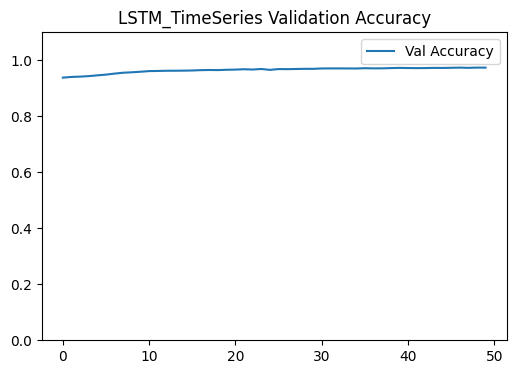


LSTM_TimeSeries MAE: 0.23331021969562404, RMSE: 0.33292138976906593
LSTM_TimeSeries Classification Report (AQI Classes 24 jam):
                                precision    recall  f1-score   support

                          Good       0.98      0.99      0.99     41900
                      Moderate       0.80      0.75      0.78      2758
Unhealthy for Sensitive Groups       0.62      0.27      0.37        30

                      accuracy                           0.97     44688
                     macro avg       0.80      0.67      0.71     44688
                  weighted avg       0.97      0.97      0.97     44688

LSTM_TimeSeries Confusion Matrix (AQI Classes 24 jam):
[[41406   494     0     0]
 [  678  2075     5     0]
 [    0    22     8     0]
 [    0     0     0     0]]


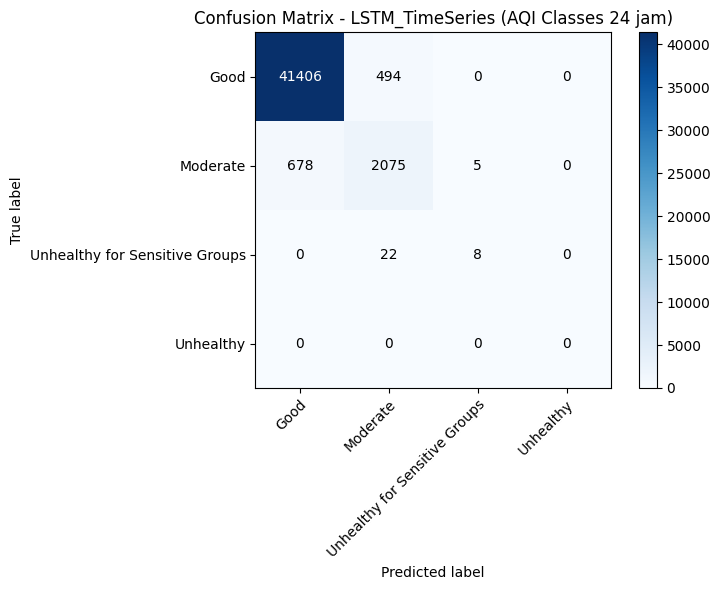

LSTM_TimeSeries Accuracy (AQI Classes 24 jam): 0.9731695309702828
Max AQI 24 jam (Pred): 119.51449324956106
Rata-rata AQI 24 jam (Pred): 24.357327969985718
Worst-case AQI 24 jam (Pred): 119.51449324956106


In [ ]:
lstm = LSTMModel(X_train_seq.shape[2], out_size=pred_len)
opt_lstm = optim.Adam(lstm.parameters(), lr=0.001, weight_decay=1e-5)
train_l_seq, val_l_seq, test_l_seq = create_loaders(X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq, is_seq=True)
hist_lstm = train_model(lstm, train_l_seq, val_l_seq, criterion, opt_lstm, is_seq=True, target_idx=single_target_idx, scaler=scaler)
plot_history(hist_lstm, 'LSTM_TimeSeries')
plot_accuracy_history(hist_lstm, 'LSTM_TimeSeries')
evaluate(lstm, test_l_seq, 'LSTM_TimeSeries', is_seq=True, target_idx=single_target_idx)

In [ ]:
torch.save(lstm.state_dict(), 'lstm.pth')
np.save('lstm_history.npy', np.array(hist_lstm, dtype=object))

print("Selesai! Model siap untuk prediksi polutan, AQI, dan time-series. File saved untuk dashboard.")

Selesai! Model siap untuk prediksi polutan, AQI, dan time-series. File saved untuk dashboard.
